In [70]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from time import time
from scipy.stats import norm

# Toy Example 6

Example in which we can make the number of iterations and the number of variables scale

In [71]:
target = 3.14
dt = 0.1
inertia = 10.0
decay = 0.9

def progr(s, beta, ret_traj=False, Nstep=15):
    
    v = 0
    ang = 0
    d = target - ang
    brakev = 0
    
    int_d = 0
    old_v = 0
    
    step = 0
    err = 0
    traj = []
    
    s1, s2, s3 = s
         
    while(step < Nstep):
        
        d = target - norm.rvs(0,beta) - ang
        
        torq = s1*d + s2*v + s3*int_d 
        
        int_d = int_d * decay + d*dt
        old_v = v
        v = v + (torq/inertia)*dt
        
        ang = ang + (v+old_v)*dt/2
    
        if ang > 2 * np.pi:
            ang = ang - 2 * np.pi
        else:
            if ang < 0:
                ang = ang + 2 * np.pi
        
        step = step + 1
        
        traj.append(ang)
        
    if ang > target - 0.01:
        if ang < target + 0.01:
            err = 0
        else:
            err = (ang-target)**2
    else:
        err = (ang - target)**2
        
    if ret_traj:
        return err, traj
    else:
        return err

In [72]:
def sample_from_progr(s, beta, n_reps):
    err_samples = []
    
    for rep in range(n_reps):
        err_samples.append(progr(s, beta))
        
    return np.mean(err_samples), np.std(err_samples)

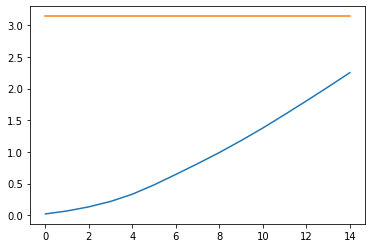

In [77]:
input_value = [10, -5, 0]
beta = np.sqrt(2)
Nstep = 15

err, traj = progr(input_value, beta, ret_traj=True, Nstep=Nstep)
plt.plot(list(range(Nstep)), traj)
plt.plot(list(range(Nstep)), [np.pi for i in range(Nstep)])

In [78]:
err

0.7924189422277028

In [79]:
mean_err, std_err = sample_from_progr(input_value, beta, int(1e3))

print('Mean error at initial value:', mean_err)
print('Std error at initial value:', std_err)

Mean error at initial value: 0.6357259225412514
Std error at initial value: 0.4720820257546066


## SAA

In [80]:
beta

1.4142135623730951

In [86]:
n_reps = int(1e4)

samples = norm.rvs(scale=beta, size=(int(Nstep), n_reps))

In [82]:
def det_progr(s, samples, ret_traj=False, Nstep=10):
    
    v = 0
    ang = 0
    brakev = 0
    
    int_d = 0
    old_v = 0
    
    step = 0
    err = 0
    traj = []
    
    s1, s2, s3 = s
         
    while(step < Nstep):
        
        d = target - samples[step] - ang
        
        torq = s1*d + s2*v + s3*int_d 
        
        int_d = int_d * decay + d*dt
        old_v = v
        v = v + (torq/inertia)*dt
        
        ang = ang + (v+old_v)*dt/2
    
        if ang > 2 * np.pi:
            ang = ang - 2 * np.pi
        else:
            if ang < 0:
                ang = ang + 2 * np.pi
        
        step = step + 1
        
        traj.append(ang)
        
    if ang > target - 0.01:
        if ang < target + 0.01:
            err = 0
        else:
            err = (ang-target)**2
    else:
        err = (ang - target)**2
        
    if ret_traj:
        return err, traj
    else:
        return err

def det_obj(s, samples):
   
    errs = []

    for i in range(samples.shape[1]):
        errs.append(det_progr(s, samples[:,i]))
    
    mean_err = np.mean(errs)
    
    return mean_err

In [83]:
input_value, beta

([10, -5, 0], 1.4142135623730951)

In [67]:
from scipy.optimize import minimize

start = time()
sample_res = minimize(det_obj, input_value, args=(samples,), method='Nelder-Mead')
end = time()

print('Time: ', round(end-start, 2))
print('Message: ', sample_res['message'])
print('N iterarions: ', sample_res['nit'])
print('Solution: ', sample_res['x'])

Time:  170.15
Message:  Optimization terminated successfully.
N iterarions:  136
Solution:  [ 4.64959525e+01 -2.30073673e+01 -3.43591328e-02]


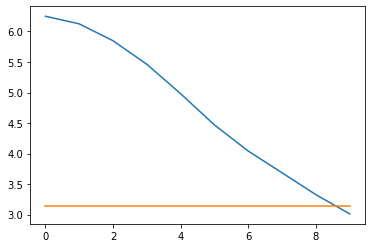

In [68]:
Nstep = 10

err, traj = progr(sample_res['x'], beta, ret_traj=True, Nstep=Nstep)
plt.plot(list(range(Nstep)), traj)
plt.plot(list(range(Nstep)), [np.pi for i in range(Nstep)])

In [69]:
mean_err, std_err = sample_from_progr(sample_res['x'], beta, int(1e3))

print('Mean error at optimized value:', mean_err)
print('Std error at optimized value:', std_err)

Mean error at optimized value: 0.6491402579219407
Std error at optimized value: 0.8312032262103265


# Gaussian Approximation

In [14]:
from compiler import *
from norm_gaussian_app import *
from time import time

In [35]:
cfg, constant_dict, var_name = process_file('Toy6.txt')

In [36]:
var_name, constant_dict

(['d',
  'ang',
  'out',
  'der_d',
  'old_der',
  'int_d',
  'torq',
  'err',
  'sum_err',
  'step'],
 {'Nstep': 15.0,
  'target': 3.14,
  'decay': 0.9,
  's1': 5.0,
  's2': -10.0,
  's3': 1.0})

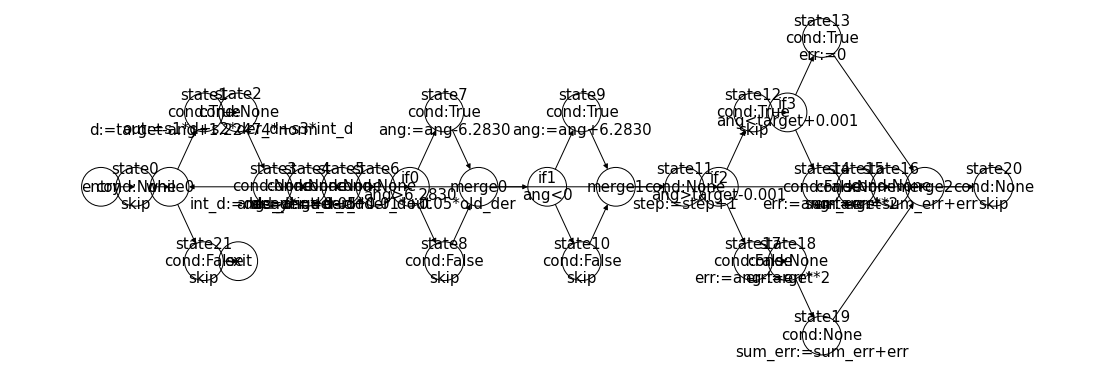

In [37]:
plt.figure(figsize=(15,5))
plot_cfg(cfg)

In [38]:
norm.ppf(0.975)

1.959963984540054

In [39]:
constant_dict['Nstep'] = Nstep
constant_dict['s1'], constant_dict['s2'], constant_dict['s3'] = input_value
constant_dict

{'Nstep': 15, 'target': 3.14, 'decay': 0.9, 's1': 10, 's2': -5, 's3': 0}

In [40]:
var_name

['d',
 'ang',
 'out',
 'der_d',
 'old_der',
 'int_d',
 'torq',
 'err',
 'sum_err',
 'step']

In [41]:
input_x = [0.]*10
input_beta = [0.]*10
K_max = 10

start = time()
output_dist = imp_smoothing(cfg, input_x, input_beta, K_max, constant_dict)
end = time()

In [50]:
print('Estimated output:', output_dist.mean()[8])
print('Estimated std in the output:', np.sqrt(output_dist.cov()[8,8]))
print('Elapsed time:', end-start)
output_dist.n_comp()

Estimated output: 78.21362230010935
Estimated std in the output: 6.294290233130683
Elapsed time: 159.15682578086853


9

## Smoothed Optimization

In [53]:
def smooth_obj_func(s_vec, constant_dict):
    s1, s2, s3 = s_vec
    constant_dict['s1'] = s1
    constant_dict['s2'] = s2
    constant_dict['s3'] = s3
    input_x = np.array([0]*10)
    input_beta = np.array([0]*10)
    K = 10
    err = imp_smoothing(cfg, input_x, input_beta, K, constant_dict).mean()[8]
    return err

In [54]:
input_value

[10, -5, 0]

In [ ]:
start = time()
smooth_res = minimize(smooth_obj_func, input_value, args=(constant_dict), method='Nelder-Mead', 
                      options={'disp':True, 'xatol':1e-6, 'fatol':1e-6, 'return_all':True})
end = time()

print('Time: ', round(end-start, 2))
print('Message: ', smooth_res['message'])
print('N iterarions: ', smooth_res['nit'])
print('Solution: ', smooth_res['x'])

In [210]:
smooth_mean, smooth_std = sample_from_progr(smooth_res['x'], 1, int(1e4))

print('Smoothly Optimized mean: ', smooth_mean)
print('Smoothly Optimized std: ', smooth_std)

Smoothly Optimized mean:  0.08101163606830544
Smoothly Optimized std:  0.11347945332240679


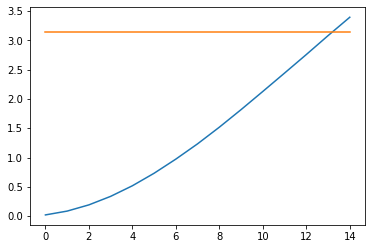

In [211]:
_, traj = progr(smooth_res['x'], 1, ret_traj = True)

plt.plot(list(range(Nstep)), traj)
plt.plot(list(range(Nstep)), [np.pi for i in range(Nstep)])

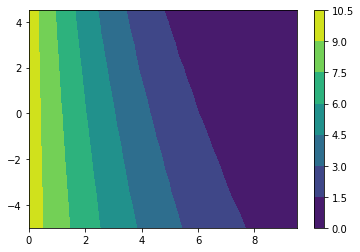

In [60]:
x, y = np.mgrid[0:10:.5, -5:5:.5]
Z_samples = np.zeros((len(x), len(y)))

for i in range(len(x)):
    for j in range(len(y)):
        Z_samples[i,j] = sample_from_progr([x[i,j], y[i,j], 0], 1, int(1e3), False)

plt.contourf(x, y, Z_samples)
plt.colorbar()